In [1]:
#!pip install numpy pandas
#!pip install scikit-learn
#!pip install tensorflow
#!pip install seaborn matplotlib

# Resumen de arquitectura


## Especificación Completa de la Arquitectura MLP

### 1. VARIABLES DE ENTRADA (Features)

**Cantidad:** 7 features

- `variables` — Número de variables de decisión en el problema de optimización
- `restricciones` — Número de restricciones
- `profundidad` — Profundidad del árbol de búsqueda
- `cota_superior` (ub_f_obj) — Cota superior del objetivo
- `cota_inferior` (lb_f_obj) — Cota inferior del objetivo
- `diametro_grande` (bigger_diam) — Diámetro mayor del intervalo
- `diametro_pequeno` (lower_diam) — Diámetro menor del intervalo

**Normalización:** StandardScaler (Media = 0, Desviación Estándar = 1)
  - Aprendida en el conjunto de entrenamiento balanceado
  - Aplicada a los conjuntos de validación y test

---

### 2. VARIABLES DE SALIDA (Target)

**Cantidad:** 6 clases (técnicas de optimización)

- `LSMEAR` — Técnica 1
- `LF` — Técnica 2
- `RR` — Técnica 3
- `SM` — Técnica 4
- `SS` — Técnica 5
- `SSR` — Técnica 6

**Formato:** Vector de probabilidades (suma = 1) de 6 dimensiones
  - Calculadas con el método **Promedio Ponderado por Mérito**
  - Representa la probabilidad de que cada heurística sea la mejor según los resultados reales

---

### 3. ARQUITECTURA DE CAPAS

```
┌─────────────────────────────────────────┐
│ ENTRADA: 7 features (StandardScaler)     │
└──────────────────┬──────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────┐
│ Capa Oculta 1: 64 neuronas, tanh         │
│   - Activación: tanh (hiperbólica)      │
│   - L2 Regularization: 1e-4             │
│   - Nombre: Hidden_Layer_1              │
└──────────────────┬──────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────┐
│ Capa Dropout: 20%                        │
│   - Desactiva aleatoriamente 20% de     │
│     neuronas para evitar overfitting    │
│   - Nombre: Dropout_1                   │
└──────────────────┬──────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────┐
│ Capa Oculta 2: 32 neuronas, tanh         │
│   - Activación: tanh (hiperbólica)      │
│   - L2 Regularization: 1e-4             │
│   - Nombre: Hidden_Layer_2              │
└──────────────────┬──────────────────────┘
┌─────────────────────────────────────────┐
│ Capa Dropout: 20%                        │
│   - Desactiva aleatoriamente 20% de     │
│     neuronas para evitar overfitting    │
│   - Nombre: Dropout_2                   │
└──────────────────┬──────────────────────┘
                   │
┌─────────────────────────────────────────┐
│ Capa Oculta 3: 16 neuronas, tanh         │
│   - Activación: tanh (hiperbólica)      │
│   - L2 Regularization: 1e-4             │
│   - Nombre: Hidden_Layer_3              │
└──────────────────┬──────────────────────┘
                   │
                   ▼
┌─────────────────────────────────────────┐
│ Capa de Salida: 6 neuronas, softmax      │
│   - Activación: softmax (probabilidades)│
│   - Entrega: vector [0,1]^6, sum=1      │
│   - Nombre: Output_Layer_Probabilities  │
└─────────────────────────────────────────┘
```

### 4. FUNCIÓN DE PÉRDIDA Y OPTIMIZACIÓN

- **Loss Function:** `KLDivergence()` — Divergencia de Kullback-Leibler
  - Mide la diferencia entre distribuciones de probabilidad reales y predichas
  - Ideal para targets probabilísticos (suavizados)

- **Optimizador:** `Adam(learning_rate=0.001, clipnorm=1.0, epsilon=1e-7)`
  - Learning Rate: 0.001 (reducida para convergencia estable)
  - Gradient Clipping: 1.0 (evita explosión de gradientes)
  - Epsilon: 1e-7 (estabilidad numérica)

- **Métricas de Evaluación:**
  - MSE (Mean Squared Error) — error cuadrático medio
  - MAE (Mean Absolute Error) — error absoluto medio
  - **Top-1 Accuracy** — ¿acierta la clase más probable?
  - **Top-3 Accuracy** — ¿está la clase correcta en las 3 mejores?

---

### 5. REGULARIZACIÓN Y CALLBACKS

**L2 Regularization:**
  - Parámetro λ = 1e-4
  - Aplicada a pesos en capas ocultas (Hidden_Layer_1 y Hidden_Layer_2)
  - Previene overfitting penalizando pesos grandes

**Dropout:**
  - Tasa: 20% (Dropout_1)
  - Ubicación: Entre capa oculta 1 y capa oculta 2
  - Efecto: Reduce co-adaptación de neuronas

**EarlyStopping:**
  - Monitorea: `val_loss` (pérdida en validación)
  - Paciencia: 15 épocas sin mejora
  - Acción: Restaura los mejores pesos encontrados

**ReduceLROnPlateau:**
  - Monitorea: `val_loss`
  - Factor: 0.2 (reduce learning rate a 20% del anterior)
  - Paciencia: 10 épocas sin mejora
  - Min LR: 1e-7 (mínimo permitido)

---

### 6. ENTRENAMIENTO

| Parámetro | Valor |
|---|---|
| **Épocas** | 250 (máximo, paró antes por EarlyStopping en ~epoch 35) |
| **Batch Size** | 32 |
| **Split Train/Val/Test** | 70% / 15% / 15% |
| **Oversampling (Train)** | Sí — Balanceo de clases al tamaño de la mayoritaria |
| **Normalización (Train/Val/Test)** | StandardScaler aprendida en train |

---



In [2]:
import re
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob

In [3]:
# BLOQUE 1: FUNCIONES PARA PARSEAR EL ARCHIVO INPUT (Features)

def _normalizar_clave(clave):
    """Normaliza una clave reemplazando caracteres especiales."""
    return clave.replace('(', '').replace(')', '').replace(' ', '')

def _procesar_valor_numerico(valor, clave, aplicar_limites, limites_por_columna, umbral_cero):
    """
    Procesa un valor numérico, manejando casos especiales como inf/nan
    y aplicando límites si es necesario.
    """
    # Manejar valores especiales
    valor_lower = valor.lower()
    if 'inf' in valor_lower:
        num_valor = np.inf
    elif 'nan' in valor_lower:
        num_valor = np.nan
    else:
        num_valor = float(valor)

    # Convertir valores muy pequeños a cero
    if np.isfinite(num_valor) and abs(num_valor) < umbral_cero:
        num_valor = 0.0

    # Aplicar límites si está habilitado
    if aplicar_limites and clave in limites_por_columna:
        lim_inf, lim_sup = limites_por_columna[clave]
        if lim_sup is not None and num_valor > lim_sup:
            print(f"Valor 'inf' o muy alto en '{clave}' recortado a {lim_sup}")
            num_valor = lim_sup
        if lim_inf is not None and num_valor < lim_inf:
            num_valor = lim_inf

    return num_valor

def parse_input_data(ruta_archivo, aplicar_limites=False):
    LIMITES_POR_COLUMNA = {
        "cota_inferior": (-1e7, 1e7),     # Equivalente a 'lb_f_obj'
        "cota_superior": (None, 10000000.0), # Equivalente a 'ub_f_obj'
        "diametro_grande": (None, 10000000.0)  # Equivalente a 'bigger_diam'
    }
    UMBRAL_CERO = 1e-7

    with open(ruta_archivo, 'r') as file:
        lineas = file.readlines()

    todos_los_registros = []
    registro_actual = {}
    
    benchmark_actual = "default_benchmark" 

    for linea in lineas:
        linea_limpia = linea.strip()

        if linea_limpia.endswith('.bch'):
            benchmark_actual = linea_limpia
            continue

        # Procesar final de registro (línea en blanco)
        if not linea_limpia:
            if registro_actual and benchmark_actual:
                registro_actual['benchmark'] = benchmark_actual
                todos_los_registros.append(registro_actual)
                registro_actual = {}
            continue

        # Procesar pares "clave: valor"
        match = re.match(r'([^:]+?)\s*:\s*(.*)', linea_limpia)
        if not match:
            continue

        clave, valor = match.groups()
        clave = _normalizar_clave(clave.strip()) # Normaliza 'cota_superior'
        valor = valor.strip()
        
        # Intentar conversión a entero primero
        try:
            registro_actual[clave] = int(valor)
            continue
        except ValueError:
            pass

        # Intentar conversión a float y aplicar procesamiento
        try:
            num_valor = _procesar_valor_numerico(valor, clave, aplicar_limites,
                                                 LIMITES_POR_COLUMNA, UMBRAL_CERO)
            registro_actual[clave] = num_valor
        except ValueError:
            # Mantener como string si no es numérico
            registro_actual[clave] = valor

    # Añadir último registro si el archivo no termina con línea en blanco
    if registro_actual and benchmark_actual:
        registro_actual['benchmark'] = benchmark_actual
        todos_los_registros.append(registro_actual)

    return todos_los_registros


In [4]:
# BLOQUE 2: FUNCIÓN PARA PARSEAR EL ARCHIVO OUTPUT (Heurísticas)
def parse_output_data(ruta_archivo):
    """
    Procesa un archivo de benchmark que contiene los resultados de las
    técnicas (ej. LSMEAR, LF, etc.).
    Estos archivos se caracterizan por tener pares clave-valor separados por espacios.
    """
    with open(ruta_archivo, 'r') as file:
        lineas = file.readlines()

    todos_los_registros = []
    registro_actual = {}
    # Misma asunción sobre benchmark
    benchmark_actual = "default_benchmark" 

    for linea in lineas:
        linea_limpia = linea.strip()

        # Identificar línea de benchmark
        if linea_limpia.endswith('.bch'):
            benchmark_actual = linea_limpia
            continue
            
        # Procesar final de registro (línea en blanco)
        if not linea_limpia:
            if registro_actual and benchmark_actual:
                registro_actual['benchmark'] = benchmark_actual
                todos_los_registros.append(registro_actual)
                registro_actual = {}
            continue

        # Procesar pares "CLAVE VALOR"
        parts = linea_limpia.split(maxsplit=1)
        if len(parts) == 2:
            clave, valor = parts
            clave = clave.strip()

            # Normalizar clave 'id:'
            if clave == 'id:':
                clave = 'id'

            try:
                registro_actual[clave] = int(valor.strip())
            except ValueError:
                registro_actual[clave] = valor.strip()

    # Añadir último registro
    if registro_actual and benchmark_actual:
        registro_actual['benchmark'] = benchmark_actual
        todos_los_registros.append(registro_actual)

    return todos_los_registros


# Procesamiento de Múltiples Archivos y Enriquecimiento del Dataset

Este bloque permite procesar múltiples parejas de archivos input/output y agregar todos los datos a un **dataframe único y acumulativo**.

In [5]:
# BLOQUE 3: PROCESAMIENTO MÚLTIPLE Y ENRIQUECIMIENTO DE DATASET

def emparejar_archivos(input_dir, output_dir):
    """
    Empareja automáticamente archivos input/output basándose en nombres similares.
    Maneja variaciones de nombres comunes.
    """
    archivos_input = sorted(glob.glob(input_dir + '*.txt'))
    archivos_a_procesar = []
    
    for input_file in archivos_input:
        basename = os.path.basename(input_file)
        basename_sin_ext = basename.replace('.txt', '')
        
        # Busca el output con el mismo nombre
        output_file = os.path.join(output_dir, basename)
        
        # Si no existe, intenta variaciones
        if not os.path.exists(output_file):
            # Reemplaza "input" por "output" en el nombre
            output_basename = basename_sin_ext.replace('input', 'output')
            output_file = os.path.join(output_dir, output_basename + '.txt')
        
        if not os.path.exists(output_file):
            # Intenta removiendo sufijos como "-1", "-2"
            output_basename = os.path.splitext(basename_sin_ext)[0].rsplit('-', 1)[0]
            output_file = os.path.join(output_dir, output_basename + '.txt')
        
        if os.path.exists(output_file):
            archivos_a_procesar.append({
                'input': input_file,
                'output': output_file
            })
            print(f"✓ Emparejado: {os.path.basename(input_file)} → {os.path.basename(output_file)}")
        else:
            print(f"✗ No encontrado output para: {basename}")
    
    return archivos_a_procesar

# 1. Define rutas
input_dir = '/home/cristopher/Escritorio/libreria/dataset/input/'
output_dir = '/home/cristopher/Escritorio/libreria/dataset/output/'

# 2. Empareja automáticamente
archivos_a_procesar = emparejar_archivos(input_dir, output_dir)

print(f"\nTotal de parejas: {len(archivos_a_procesar)}\n")




✓ Emparejado: easy_ex2_1_1.txt → easy_ex2_1_1.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_ex2_1_7.txt → optimizer_output_benchs_victor_fixxed_ex2_1_7.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_ex2_1_8.txt → optimizer_output_benchs_victor_fixxed_ex2_1_8.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_himmelbk.txt → optimizer_output_benchs_victor_fixxed_himmelbk.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_hs056.txt → optimizer_output_benchs_victor_fixxed_hs056.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_hs070.txt → optimizer_output_benchs_victor_fixxed_hs070.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_hs087.txt → optimizer_output_benchs_victor_fixxed_hs087.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_hs088.txt → optimizer_output_benchs_victor_fixxed_hs088.txt
✓ Emparejado: optimizer_input_benchs_victor_fixxed_hs089.txt → optimizer_output_benchs_victor_fixxed_hs089.txt
✓ Emparejado: optimizer_input_benchs_victor_fixx

In [6]:
# 2. Inicializa el dataframe final (vacío al inicio)
df_final = pd.DataFrame()

print("="*60)
print("INICIANDO PROCESAMIENTO DE MÚLTIPLES ARCHIVOS")
print("="*60)

# 3. Procesa cada pareja de archivos
for idx, archivo_pareja in enumerate(archivos_a_procesar, 1):
    ruta_input = archivo_pareja['input']
    ruta_output = archivo_pareja['output']
    
    # Verifica que los archivos existan
    if not os.path.exists(ruta_input):
        print(f"\n [{idx}] ADVERTENCIA: Archivo input NO ENCONTRADO: {ruta_input}")
        continue
    if not os.path.exists(ruta_output):
        print(f"\n [{idx}] ADVERTENCIA: Archivo output NO ENCONTRADO: {ruta_output}")
        continue
    
    print(f"\n--- Procesando pareja [{idx}] ---")
    print(f"Input:  {os.path.basename(ruta_input)}")
    print(f"Output: {os.path.basename(ruta_output)}")
    
    try:
        # 4. Parsea los archivos
        datos_input = parse_input_data(ruta_input, aplicar_limites=True)
        datos_output = parse_output_data(ruta_output)
        
        # 5. Convierte a DataFrames
        df_input = pd.DataFrame(datos_input)
        df_output = pd.DataFrame(datos_output)
        
        print(f"  Filas input: {len(df_input)}")
        print(f"  Filas output: {len(df_output)}")
        
        # 6. Une los DataFrames
        df_merged_local = pd.merge(df_input, df_output, on=['benchmark', 'id'])
        print(f"  Filas después del merge: {len(df_merged_local)}")
        
        # 7. Limpieza de datos
        columnas_tecnicas = ['LSMEAR', 'LF', 'RR', 'SM', 'SS', 'SSR']
        
        for columna in columnas_tecnicas:
            if columna not in df_merged_local.columns:
                df_merged_local[columna] = -1
            else:
                df_merged_local[columna] = df_merged_local[columna].fillna(-1)
        
        df_merged_local[columnas_tecnicas] = df_merged_local[columnas_tecnicas].astype(int)
        
        # 8. Ordena las columnas
        features_reales = ['variables', 'restricciones', 'profundidad', 'cota_superior', 
                          'cota_inferior', 'diametro_grande', 'diametro_pequeno']
        
        ordered_columns = ['benchmark', 'id'] + features_reales + columnas_tecnicas
        df_merged_local = df_merged_local.reindex(columns=ordered_columns)
        
        # 9. ACUMULA EN df_final (concatena)
        df_final = pd.concat([df_final, df_merged_local], ignore_index=False)
        print(f"  ✓ Agregado a dataset. Total acumulado: {len(df_final)}")
        
    except Exception as e:
        print(f"  ✗ ERROR procesando esta pareja: {str(e)}")
        continue

print("\n" + "="*60)
print(f"PROCESAMIENTO COMPLETADO")
print("="*60)
print(f"Filas totales en df_final: {len(df_final)}")
print(f"\nPrimeras filas del dataset enriquecido:")
print(df_final.head())

print(f"\nVerificación de NaN:")
print(df_final.isna().sum())


INICIANDO PROCESAMIENTO DE MÚLTIPLES ARCHIVOS

--- Procesando pareja [1] ---
Input:  easy_ex2_1_1.txt
Output: easy_ex2_1_1.txt
  Filas input: 38
  Filas output: 38
  Filas después del merge: 38
  ✓ Agregado a dataset. Total acumulado: 38

--- Procesando pareja [2] ---
Input:  optimizer_input_benchs_victor_fixxed_ex2_1_7.txt
Output: optimizer_output_benchs_victor_fixxed_ex2_1_7.txt
  Filas input: 280
  Filas output: 280
  Filas después del merge: 280
  ✓ Agregado a dataset. Total acumulado: 318

--- Procesando pareja [3] ---
Input:  optimizer_input_benchs_victor_fixxed_ex2_1_8.txt
Output: optimizer_output_benchs_victor_fixxed_ex2_1_8.txt
  Filas input: 227
  Filas output: 227
  Filas después del merge: 227
  ✓ Agregado a dataset. Total acumulado: 545

--- Procesando pareja [4] ---
Input:  optimizer_input_benchs_victor_fixxed_himmelbk.txt
Output: optimizer_output_benchs_victor_fixxed_himmelbk.txt
Valor 'inf' o muy alto en 'cota_superior' recortado a 10000000.0
Valor 'inf' o muy alto en '

In [7]:
# BLOQUE 3.5: GUARDAR Y CARGAR DATASET EN EXCEL

nombre_archivo_excel = 'dataset.xlsx'

# Guardar el dataset actual
df_final.to_excel(nombre_archivo_excel, index=False)
print(f"✓ Dataset guardado en: {nombre_archivo_excel}")
print(f"  Total de filas: {len(df_final)}")


✓ Dataset guardado en: dataset.xlsx
  Total de filas: 33965


### Calculo de probabilidades

In [8]:
# 1. DEFINIR FEATURES Y TÉCNICAS

features = ['variables', 'restricciones', 'profundidad', 'cota_superior', 
            'cota_inferior', 'diametro_grande', 'diametro_pequeno']
techniques = ['LSMEAR', 'LF', 'RR', 'SM', 'SS', 'SSR']

print(f"Dataset original (df_final): {len(df_final)} filas")

# 2. FILTRA FILAS INVÁLIDAS (redundante?)
filas_validas = (df_final[techniques] != -1).all(axis=1)
df_final_limpio = df_final[filas_validas].copy()

print(f"Dataset filtrado (sin -1): {len(df_final_limpio)} filas")

# 3. SEPARA X (FEATURES) E Y (TARGETS BRUTOS)
X = df_final_limpio[features]
Y_raw = df_final_limpio[techniques]


Dataset original (df_final): 33965 filas
Dataset filtrado (sin -1): 33965 filas


In [9]:
# 4. FUNCIÓN PARA CALCULAR PROBABILIDADES 
def calcular_probabilidades_por_promedio(nodos):
    # 1. Filtrar valores válidos
    nodos_validos = nodos[nodos >= 0]
    if nodos_validos.empty:
        return pd.Series(0.0, index=nodos.index)

    # 2. Calcular el PROMEDIO
    promedio = nodos_validos.mean()

    # 3. Filtrar: Solo sobreviven las técnicas MEJORES (menores) al promedio
    calificadas_mask = (nodos_validos <= promedio)
    tecnicas_calificadas = nodos_validos[calificadas_mask]
    
    probabilidades = pd.Series(0.0, index=nodos.index)

    # Caso especial: Si ninguna califica (raro) o empate total
    if tecnicas_calificadas.empty:
        valor_minimo = nodos_validos.min()
        mejores_tecnicas_mask = (nodos_validos == valor_minimo)
        num_ganadores = mejores_tecnicas_mask.sum()
        if num_ganadores > 0:
            probabilidades[mejores_tecnicas_mask] = 1.0 / num_ganadores
        return probabilidades

    # 4. Calcular Mérito: Distancia desde el promedio
    # (Promedio - Valor) -> Mientras más chico el valor, más grande el mérito
    merito = promedio - tecnicas_calificadas

    suma_meritos = merito.sum()

    # 5. Normalizar (Crear porcentajes)
    if suma_meritos > 0:
        probabilidades.update(merito / suma_meritos)
    else:
        # Si todas las calificadas son iguales al promedio
        num_calificadas = len(tecnicas_calificadas)
        probabilidades[tecnicas_calificadas.index] = 1.0 / num_calificadas

    return probabilidades


In [10]:

# 5. APLICA PARA CREAR VERDADERA 'y'
# .apply(..., axis=1) aplica la función a CADA FILA del DataFrame
y = Y_raw.apply(calcular_probabilidades_por_promedio, axis=1)
print("Variable objetivo 'y' (probabilidades) creada")

# 6. VERIFICA EL RESULTADO
print("\n--- Ejemplo de Y_raw (Resultados Brutos) ---")
print(Y_raw.head())

print("\n--- Ejemplo de 'y' (Probabilidades Objetivo - Método 'Peor Valor') ---")
print(y.head())

print("\n--- Verificación: la suma de probabilidades por fila debe ser 1 (o 0) ---")
print(y.sum(axis=1).head())

Variable objetivo 'y' (probabilidades) creada

--- Ejemplo de Y_raw (Resultados Brutos) ---
   LSMEAR  LF  RR  SM  SS  SSR
0       8  14  14  18  18   18
1       2   4   2   2   2    2
2       6  16   6   6   6    6
3      10  20  14  18  18   20
4       4  14   4   4   4    4

--- Ejemplo de 'y' (Probabilidades Objetivo - Método 'Peor Valor') ---
     LSMEAR        LF        RR   SM   SS  SSR
0  0.777778  0.111111  0.111111  0.0  0.0  0.0
1  0.200000  0.000000  0.200000  0.2  0.2  0.2
2  0.200000  0.000000  0.200000  0.2  0.2  0.2
3  0.714286  0.000000  0.285714  0.0  0.0  0.0
4  0.200000  0.000000  0.200000  0.2  0.2  0.2

--- Verificación: la suma de probabilidades por fila debe ser 1 (o 0) ---
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64


### Diagnostico del balance de los datos

Distribución de clases (Heurística ganadora):
LSMEAR    13043
LF         8564
RR         4168
SM         3473
SSR        2547
SS         2170
Name: count, dtype: int64


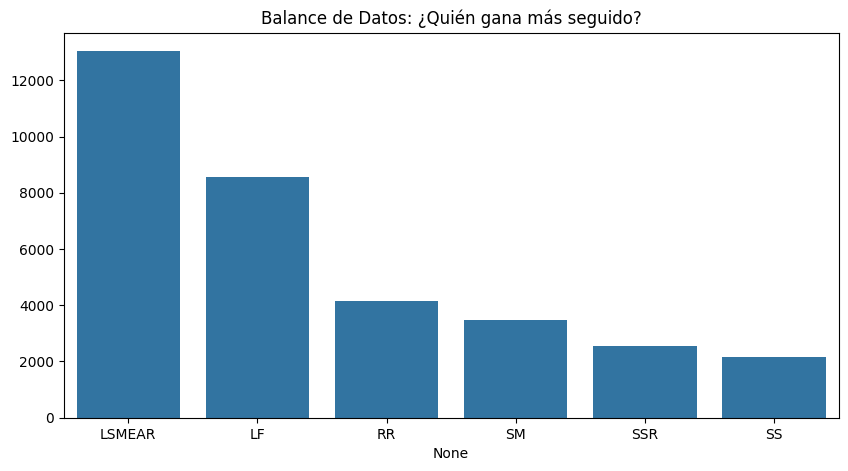

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vemos quién gana en cada fila
ganadores = y.idxmax(axis=1)
conteo = ganadores.value_counts()

print("Distribución de clases (Heurística ganadora):")
print(conteo)

plt.figure(figsize=(10, 5))
sns.barplot(x=conteo.index, y=conteo.values)
plt.title("Balance de Datos: ¿Quién gana más seguido?")
plt.show()

In [12]:
sum = 0.113208 + 0.283019 + 0.207547 + 0.264151 + 0.000000 + 0.132075
print(f"\nSuma de probabilidades ejemplo: {sum}")


Suma de probabilidades ejemplo: 1.0


### División del dataset


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
# X =  DataFrame de features 
# y =  DataFrame de probabilidades 

# Primera División: Separar Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)

# Segunda División: Separar Train (70%) y Validation (15%)
# 15% del total es aprox 17.65% del restante
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765, 
    random_state=42
)

print("--- Dimensiones Originales ---")
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


# APLICAR OVERSAMPLING (solo al entrenamiento)

def aplicar_oversampling_soft(X_in, y_in):
    # 1. Identificar ganador por fila
    ganadores = y_in.idxmax(axis=1)
    
    # 2. Unir temporalmente para resamplear junto
    data = pd.concat([X_in, y_in], axis=1)
    data['ganador_temp'] = ganadores
    
    # 3. Calcular meta (igualar al mayoritario)
    conteo = data['ganador_temp'].value_counts()
    max_samples = conteo.max()
    clases = data['ganador_temp'].unique()
    
    print(f"\nAplicando Oversampling...")
    print(f"Meta: Elevar todas las clases a {max_samples} muestras.")
    
    dfs_resampled = []
    
    for clase in clases:
        df_clase = data[data['ganador_temp'] == clase]
        
        # Si la clase ya es la mayoritaria, no hacemos nada (o copiamos)
        # Si es minoritaria, hacemos resample con reemplazo
        df_clase_resampled = resample(
            df_clase,
            replace=True,
            n_samples=max_samples,
            random_state=42
        )
        dfs_resampled.append(df_clase_resampled)
        
    # 4. Concatenar y mezclar
    data_balanced = pd.concat(dfs_resampled).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # 5. Separar de nuevo X e y
    cols_tecnicas = y_in.columns.tolist()
    y_out = data_balanced[cols_tecnicas]
    X_out = data_balanced.drop(columns=cols_tecnicas + ['ganador_temp'])
    
    return X_out, y_out

# --- EJECUCIÓN DEL OVERSAMPLING ---
# Sobrescribimos X_train e y_train con las versiones balanceadas
X_train, y_train = aplicar_oversampling_soft(X_train, y_train)

print(f"\n--- Dimensiones tras Oversampling ---")
print(f"Train Balanceado: {len(X_train)} (Las filas aumentaron)")


# 3. NORMALIZAR LAS FEATURES (YA BALANCEADO)
print("\nNormalizando datos con StandardScaler...")

scaler = StandardScaler()

# "Aprender" la media y std del X_train (que ahora está balanceado)
scaler.fit(X_train)
# mlp_3_tanh_oversampling

joblib.dump(scaler, 'scaler_3_tanh_temperature.pkl')
print("¡scaler.pkl generado correctamente!")

# Transformar los TRES conjuntos
# Nota: Val y Test NO se balancearon (es correcto), pero se escalan con el scaler de Train
X_train_scaled_np = scaler.transform(X_train)
X_val_scaled_np = scaler.transform(X_val)
X_test_scaled_np = scaler.transform(X_test)

print("¡Datos normalizados!")

# Convertir de nuevo a DataFrame para mantener nombres de columnas
features_cols = X.columns
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=features_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled_np, columns=features_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=features_cols, index=X_test.index)

# Reiniciar índices de y_train para que coincidan con X_train_scaled (importante tras resampling)
y_train = y_train.reset_index(drop=True)

print("\n--- Ejemplo de X_train_scaled (Balanceado y Normalizado) ---")
print(X_train_scaled.head())

--- Dimensiones Originales ---
Train: 23774 | Val: 5096 | Test: 5095

Aplicando Oversampling...
Meta: Elevar todas las clases a 9170 muestras.

--- Dimensiones tras Oversampling ---
Train Balanceado: 55020 (Las filas aumentaron)

Normalizando datos con StandardScaler...
¡scaler.pkl generado correctamente!
¡Datos normalizados!

--- Ejemplo de X_train_scaled (Balanceado y Normalizado) ---
   variables  restricciones  profundidad  cota_superior  cota_inferior  \
0  -0.810876      -0.879322    -0.325330       0.643171       0.352855   
1  -1.375555      -0.978031    -0.091497       0.643171       0.352855   
2  -0.669707      -0.681905    -0.291926       0.643171       0.352855   
3  -0.810876      -0.484487    -0.325330      -1.554936       0.352728   
4  -0.669707      -0.879322    -0.091497       0.643171       0.352855   

   diametro_grande  diametro_pequeno  
0         6.470563         -0.012657  
1        -0.164320         -0.012657  
2        -0.164319         -0.012657  
3        

# Primer modelo de red neuronal


## Modelo:

### 1. DEFINIR LA ARQUITECTURA 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. DEFINIR LA ARQUITECTURA - PATRÓN "ESTIRAR Y COMPRIMIR"

model = Sequential(name="MLP_modelo_1")

# Capa de Entrada
model.add(InputLayer(shape=(X_train_scaled.shape[1],)))

# Segunda Capa Oculta: 64 neuronas, activación 'tanh' (ESTIRAR)
model.add(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(1e-4),name="Hidden_Layer_1_Expand"))

# Capa de Dropout (0.2) - Regularización adicional en el cuello de botella
model.add(Dropout(0.2, name="Dropout_1"))

model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(1e-4),name="Hidden_Layer_2_Compress"))

# Capa de Dropout (0.2) - Regularización adicional antes de comprimir más
model.add(Dropout(0.2, name="Dropout_2"))


model.add(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(1e-4),name="Hidden_Layer_3_Compress_Final"))

# --- INICIO DEL CAMBIO ---
# Definir temperatura (T=0.8 según tu tesis)
TEMPERATURE = 0.8
def softmax_temperature(logits):
    return tf.nn.softmax(logits / TEMPERATURE)

# 1. Capa de Salida (Logits crudos, SIN activación)
model.add(Dense(len(techniques), 
                activation=None, 
                name="Output_Layer_Logits"))

# 2. Capa Lambda para aplicar Softmax con Temperatura
model.add(Lambda(softmax_temperature, name=f"Softmax_Temperature_{TEMPERATURE}"))
# --- FIN DEL CAMBIO ---

model.summary()




2025-12-06 00:24:06.622082: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 00:24:06.672050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 00:24:08.244576: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
E0000 00:00:1764991448.474465   18066 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764991448.478126   18066 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are install

Model: "MLP_modelo_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1_Expand (Dense)   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2_Compress (Dense) │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3_Compress_Final   │ (None, 16)             │           528 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer_Logits (Dense)     │ (None, 6)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax_Temperature_0.8         │ (None, 6)              │             0 │
│ (Lambda)                        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,222 (12.59 KB)

 Trainable params: 3,222 (12.59 KB)

 Non-trainable params: 0 (0.00 B)

### 2. COMPILAR EL MODELO

In [15]:
# 2. COMPILAR EL MODELO
print("\nCompilando el modelo...")

# Optimizador con 
optimizer = Adam(
    learning_rate=0.001, 
    clipnorm=1.0,
    epsilon=1e-7
)

# Como la última capa TIENE softmax -> from_logits=False (valor por defecto)
loss_fn = tf.keras.losses.KLDivergence() 

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['mse', 'mae'])

print("¡Modelo compilado!")


Compilando el modelo...
¡Modelo compilado!


### 3. DEFINIR CALLBACKS Y ENTRENAR

In [16]:

# 3. DEFINIR CALLBACKS Y ENTRENAR
early_stopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1)

print("\n--- Iniciando Entrenamiento ---")

EPOCHS = 250  
BATCH_SIZE = 32 

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_scaled, y_val), 
    callbacks=[early_stopper, lr_reducer],
    verbose=1
)

# Guardar el modelo (formato Keras moderno .keras)
model.save('mlp_3_tanh_temperature.keras')
print("\nModelo original guardado como 'mlp_3_tanh_temperature.keras'")


--- Iniciando Entrenamiento ---
Epoch 1/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.7325 - mae: 0.1577 - mse: 0.0383 - val_loss: 0.7077 - val_mae: 0.1530 - val_mse: 0.0370 - learning_rate: 0.0010
Epoch 2/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.7056 - mae: 0.1531 - mse: 0.0368 - val_loss: 0.6757 - val_mae: 0.1479 - val_mse: 0.0352 - learning_rate: 0.0010
Epoch 3/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.6896 - mae: 0.1498 - mse: 0.0359 - val_loss: 0.6614 - val_mae: 0.1448 - val_mse: 0.0344 - learning_rate: 0.0010
Epoch 4/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6810 - mae: 0.1479 - mse: 0.0354 - val_loss: 0.6645 - val_mae: 0.1448 - val_mse: 0.0345 - learning_rate: 0.0010
Epoch 5/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.6769 - mae: 0.1471 - mse: 0.0352 - val_loss: 0.6535 - val_mae: 0.1427 - val_mse: 0.0339 - learning_rate: 0.0010
Epoch 6/250
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6737 - mae: 

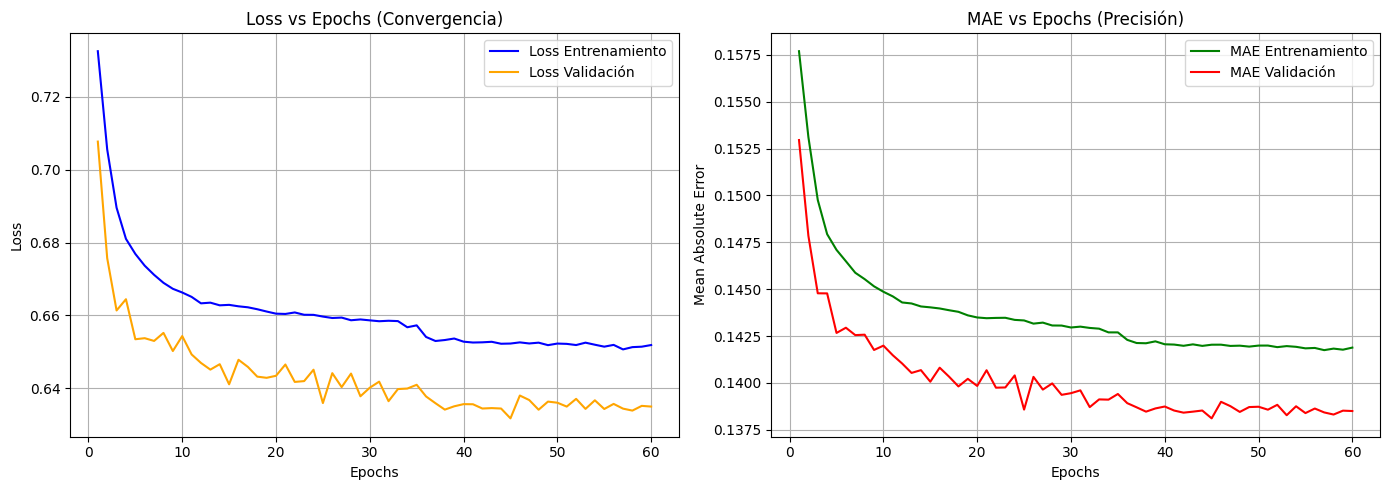

In [17]:
import matplotlib.pyplot as plt

def graficar_entrenamiento(history):
    # Extraer datos del historial
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    # Crear una figura con dos subgráficos (1 fila, 2 columnas)
    plt.figure(figsize=(14, 5))

    # --- Gráfico 1: Loss (Convergencia Matemática) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['loss'], label='Loss Entrenamiento', color='blue')
    # Solo graficar validación si existe
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='Loss Validación', color='orange')
    
    plt.title('Loss vs Epochs (Convergencia)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Gráfico 2: MAE (Precisión Humana) ---
    plt.subplot(1, 2, 2)
    # Nota: Keras a veces guarda la clave como 'mae' o 'mean_absolute_error'
    # Este truco asegura que encuentre la clave correcta
    mae_key = 'mae' if 'mae' in hist else 'mean_absolute_error'
    val_mae_key = 'val_' + mae_key
    
    plt.plot(epochs, hist[mae_key], label='MAE Entrenamiento', color='green')
    if val_mae_key in hist:
        plt.plot(epochs, hist[val_mae_key], label='MAE Validación', color='red')

    plt.title('MAE vs Epochs (Precisión)')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejecutar la función
graficar_entrenamiento(history)

## Entrenamiento primer modelo

## Test primer modelo

EVALUACIÓN COMPLETA EN TEST
Test Loss (KL Divergence): 0.6218
Test MSE: 0.0319
Test MAE: 0.1365
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Top-1 Accuracy: 0.2899
Test Top-3 Accuracy: 0.6251


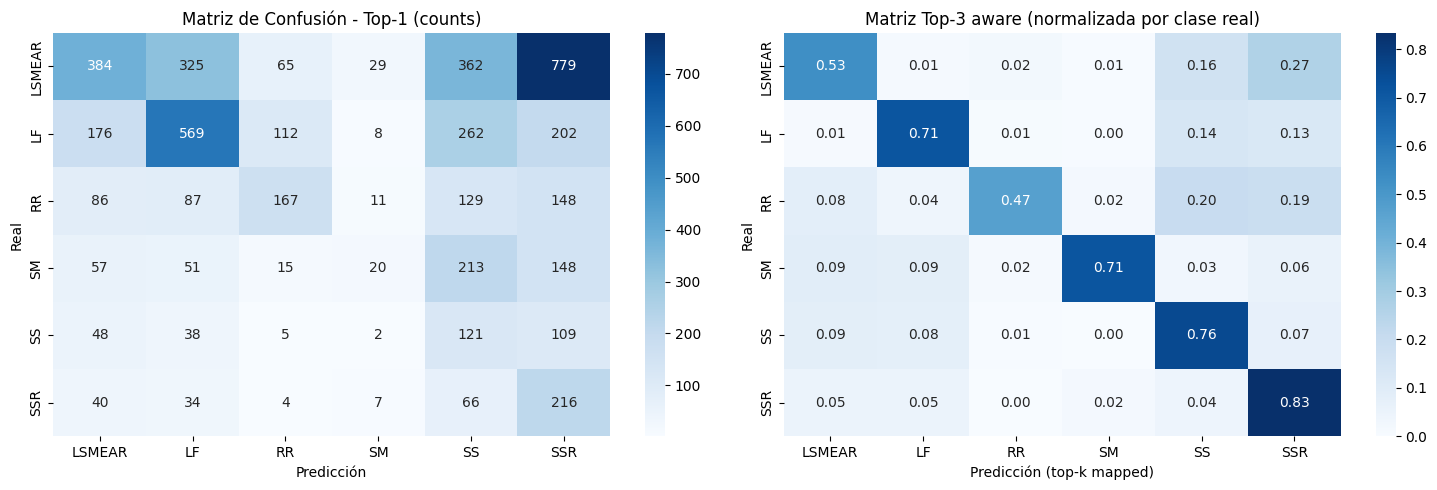


Matriz Top-1 (counts):
[[384 325  65  29 362 779]
 [176 569 112   8 262 202]
 [ 86  87 167  11 129 148]
 [ 57  51  15  20 213 148]
 [ 48  38   5   2 121 109]
 [ 40  34   4   7  66 216]]

Matriz Top-3 aware (counts, mapeada):
[[1029   26   41   12  320  516]
 [  14  950   10    5  183  167]
 [  52   25  296   11  125  119]
 [  46   44    8  360   15   31]
 [  28   26    2    0  244   23]
 [  18   19    1    7   16  306]]


In [18]:
print("EVALUACIÓN COMPLETA EN TEST")

# 1. Evaluar las métricas de pérdida y error en el test
test_loss, test_mse, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (KL Divergence): {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 2. Obtener las predicciones para todo el test set
y_test_pred = model.predict(X_test_scaled)

# 3. Calcular la precisión (accuracy) comparando la heurística más probable (Top-1)
def calcular_accuracy(y_true, y_pred):
    aciertos = 0
    for i in range(len(y_true)):
        true_best = np.argmax(y_true.iloc[i])
        pred_best = np.argmax(y_pred[i])
        if true_best == pred_best:
            aciertos += 1
    return aciertos / len(y_true)

# Función Top-K (general)
def calcular_top_k_accuracy(y_true, y_pred, k=3):
    aciertos = 0
    for i in range(len(y_true)):
        true_class = np.argmax(y_true.iloc[i])
        top_k_pred = np.argsort(y_pred[i])[-k:]
        if true_class in top_k_pred:
            aciertos += 1
    return aciertos / len(y_true)

# Calcular Top-1 y Top-3
test_top1 = calcular_accuracy(y_test, y_test_pred)
test_top3 = calcular_top_k_accuracy(y_test, y_test_pred, k=3)

# Usar Top-3 como métrica principal a partir de ahora
test_accuracy = test_top3

print(f"Test Top-1 Accuracy: {test_top1:.4f}")
print(f"Test Top-3 Accuracy: {test_top3:.4f}")

# 4. Mostrar la matriz de confusión considerando Top-3 (modificado aquí en la misma celda)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Etiquetas reales (Top-1 de y_test)
y_true_labels = [np.argmax(row) for _, row in y_test.iterrows()]

# Predicción Top-1
y_pred_top1 = [np.argmax(row) for row in y_test_pred]
cm_top1 = confusion_matrix(y_true_labels, y_pred_top1)

# Construir una matriz de confusión "Top-3 aware" (mapeo):
# - Si la clase real está en el top-3 de la predicción -> la contamos como predicha correctamente (mapeada a la clase real)
# - Si no está en el top-3 -> contamos la predicción Top-1 (error) para conservar una etiqueta por muestra
k = 3
y_pred_top3_mapped = []
for i, probs in enumerate(y_test_pred):
    topk = np.argsort(probs)[-k:]
    true_cls = y_true_labels[i]
    if true_cls in topk:
        # Consideramos que el modelo 'predijo' correctamente la clase real
        y_pred_top3_mapped.append(true_cls)
    else:
        # No está en top-k -> tomamos la predicción top-1 (error)
        y_pred_top3_mapped.append(np.argmax(probs))

cm_top3_mapped = confusion_matrix(y_true_labels, y_pred_top3_mapped)

# Visualización: mostrar ambas matrices (Top-1 counts y Top-3 aware normalized)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Top-1 (counts)
sns.heatmap(cm_top1, annot=True, fmt='d', cmap='Blues', xticklabels=techniques, yticklabels=techniques, ax=axes[0])
axes[0].set_title('Matriz de Confusión - Top-1 (counts)')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Top-3 mapped (normalizar por fila para ver fracciones correctas por clase)
cm_top3_mapped_norm = cm_top3_mapped.astype('float')
row_sums = cm_top3_mapped_norm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
cm_top3_mapped_norm = cm_top3_mapped_norm / row_sums
sns.heatmap(cm_top3_mapped_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=techniques, yticklabels=techniques, ax=axes[1])
axes[1].set_title(f'Matriz Top-{k} aware (normalizada por clase real)')
axes[1].set_xlabel('Predicción (top-k mapped)')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# También imprimimos las matrices en consola para inspección numérica
print('\nMatriz Top-1 (counts):')
print(cm_top1)
print('\nMatriz Top-3 aware (counts, mapeada):')
print(cm_top3_mapped)

# Nota: para métricas por clase (Top-3 recall) usa el bloque Top-k que ya tienes disponible en el notebook.

In [19]:
# BLOQUE: DIAGNÓSTICOs

print("DIAGNÓSTICO DEL MODELO")

# 1. Verificar distribución de clases
print("1. DISTRIBUCIÓN DE CLASES EN y_train:")
class_distribution = y_train.idxmax(axis=1).value_counts()
print(class_distribution)

# 2. Verificar datos de entrada
print("\n2. ESTADÍSTICAS DE X_train_scaled:")
print(X_train_scaled.describe())

# 3. Verificar si hay desbalance extremo
print("\n3. ANÁLISIS DE DESBALANCE:")
total_ejemplos = len(y_train)
for i, tech in enumerate(techniques):
    count = (y_train.iloc[:, i] == y_train.iloc[:, i].max()).sum()
    porcentaje = (count / total_ejemplos) * 100
    print(f"  {tech}: {count} ejemplos ({porcentaje:.1f}%)")

# 4. Probar predicción aleatoria (baseline)
print("\n4. BASELINE ALEATORIO:")
accuracy_aleatorio = 1 / len(techniques)
print(f"Accuracy esperado por azar: {accuracy_aleatorio:.3f} ({accuracy_aleatorio*100:.1f}%)")
print(f"Tu modelo: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

DIAGNÓSTICO DEL MODELO
1. DISTRIBUCIÓN DE CLASES EN y_train:
SM        9170
LSMEAR    9170
LF        9170
SS        9170
SSR       9170
RR        9170
Name: count, dtype: int64

2. ESTADÍSTICAS DE X_train_scaled:
          variables  restricciones   profundidad  cota_superior  \
count  5.502000e+04   5.502000e+04  5.502000e+04   5.502000e+04   
mean  -6.198846e-18   3.719308e-17  8.342614e-17   1.811871e-16   
std    1.000009e+00   1.000009e+00  1.000009e+00   1.000009e+00   
min   -1.375555e+00  -1.076740e+00 -1.260664e+00  -1.555566e+00   
25%   -6.697067e-01  -5.831956e-01 -6.927830e-01  -1.554935e+00   
50%   -2.461977e-01  -2.870687e-01 -3.587353e-01   6.431710e-01   
75%    3.184811e-01   3.051851e-01  3.761699e-01   6.431710e-01   
max    3.706553e+00   3.858708e+00  3.917076e+00   6.431710e-01   

       cota_inferior  diametro_grande  diametro_pequeno  
count   5.502000e+04     5.502000e+04      5.502000e+04  
mean   -4.158393e-17    -1.213941e-17      8.394271e-19  
std     1